In [1]:
import bisect
import itertools
import pickle
import random
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

#plt.rcParams.update({'font.size': 12})

sys.path.append('../gmia/simulators')

from simantha import Source, Machine, Buffer, Sink, Maintainer, System, utils
#from simantha.utils import *

In [2]:
system = pickle.load(open('C:/Users/Michael/Downloads/system_000.pkl', 'rb'))

In [3]:
system.simulate(simulation_time=1440)

Failed event:
  time:     76
  location: M3
  action:   maintain
  priority: 0


SystemExit: 

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
system.machines[0].cm_distribution

[5, 15]

In [4]:
%tb

SystemExit: 

In [42]:
for exp in itertools.product(*[range(len(v)) for v in factors.values()]):
    print(exp)

(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 0, 3)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 1, 3)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
(0, 2, 3)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 0, 3)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 2, 0)
(1, 2, 1)
(1, 2, 2)
(1, 2, 3)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 0, 3)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(2, 2, 0)
(2, 2, 1)
(2, 2, 2)
(2, 2, 3)


In [41]:
factors = {
    'degradation_rate': [0.05, 0.10, 0.15],
    'maintenance_capacity': [1, 2, 3],
    'cm_distribution': [[5, 15], [12, 28], [29, 51], [50, 60]]
}

def experiment(degradation, capacity, cm):
    print(f'degradation: {degradation}')
    print(f'capacity: {capacity}')
    print(f'cm: {cm}')
    print()

for lvl, exp in zip(itertools.product(*[[0, 1, 2]]*3), itertools.product(*factors.values())):
    #xperiment(*exp)
    print(''.join([str(L) for L in lvl]), exp)

000 (0.05, 1, [5, 15])
001 (0.05, 1, [12, 28])
002 (0.05, 1, [29, 51])
010 (0.05, 1, [50, 60])
011 (0.05, 2, [5, 15])
012 (0.05, 2, [12, 28])
020 (0.05, 2, [29, 51])
021 (0.05, 2, [50, 60])
022 (0.05, 3, [5, 15])
100 (0.05, 3, [12, 28])
101 (0.05, 3, [29, 51])
102 (0.05, 3, [50, 60])
110 (0.1, 1, [5, 15])
111 (0.1, 1, [12, 28])
112 (0.1, 1, [29, 51])
120 (0.1, 1, [50, 60])
121 (0.1, 2, [5, 15])
122 (0.1, 2, [12, 28])
200 (0.1, 2, [29, 51])
201 (0.1, 2, [50, 60])
202 (0.1, 3, [5, 15])
210 (0.1, 3, [12, 28])
211 (0.1, 3, [29, 51])
212 (0.1, 3, [50, 60])
220 (0.15, 1, [5, 15])
221 (0.15, 1, [12, 28])
222 (0.15, 1, [29, 51])


In [7]:
%%timeit
degradation_rate = 0.05#0.025
h_max = 10
pm_distribution = {'uniform': [5, 10]}
cm_distribution = {'uniform': [20, 30]}
maintenance_capacity = 1
buffer_capacity = 10

warm_up_time = utils.WEEK
simulation_time = utils.WEEK
##########################

Q = utils.generate_degradation_matrix(p=degradation_rate, h_max=h_max)

# define objects
source = Source()

M1 = Machine('M1', cycle_time=1, degradation_matrix=Q) # station 1
station1 = [M1]

B1 = Buffer('B1', capacity=buffer_capacity)

M2 = Machine('M2', cycle_time=2, degradation_matrix=Q) # station 2
station2 = [M2]

B2 = Buffer('B2', capacity=buffer_capacity)

M3 = Machine('M3', cycle_time=6, degradation_matrix=Q) # station 3
M4 = Machine('M4', cycle_time=6, degradation_matrix=Q)
M5 = Machine('M5', cycle_time=6, degradation_matrix=Q)
station3 = [M3, M4, M5]

M6 = Machine('M6', cycle_time=4, degradation_matrix=Q) # station 4
M7 = Machine('M7', cycle_time=4, degradation_matrix=Q)
station4 = [M6, M7]

B3 = Buffer('B3', capacity=buffer_capacity)

M8 = Machine('M8', cycle_time=2, degradation_matrix=Q) # station 5
station5 = [M8]

B4 = Buffer('B4', capacity=buffer_capacity)

M9 = Machine('M9', cycle_time=1, degradation_matrix=Q) # station 6
station6 = [M9]

sink = Sink()

stations = [station1, station2, station3, station4, station5, station6]
machines = [machine for station in stations for machine in station]
buffers = [B1, B2, B3, B4]

for machine in machines:
    machine.pm_distribution = pm_distribution
    machine.cm_distribution = cm_distribution

# define routing
source.define_routing(downstream=station1)
M1.define_routing(upstream=[source], downstream=[B1])
B1.define_routing(upstream=station1, downstream=station2+station4)
M2.define_routing(upstream=[B1], downstream=[B2])
B2.define_routing(upstream=station2, downstream=station3)
for machine in station3:
    machine.define_routing(upstream=[B2], downstream=[B4])
for machine in station4:
    machine.define_routing(upstream=[B1], downstream=[B3])
B3.define_routing(upstream=station4, downstream=station5)
M8.define_routing(upstream=[B3], downstream=[B4])
B4.define_routing(upstream=station3+station5, downstream=station6)
M9.define_routing(upstream=[B4], downstream=[sink])
sink.define_routing(upstream=station6)

maintainer = Maintainer(capacity=maintenance_capacity)

system = System(objects=[source]+machines+buffers+[sink], maintainer=maintainer)

10000 loops, best of 3: 84 µs per loop


In [9]:
pickle.dump(system, open('system.pkl', 'wb'))

In [15]:
%%timeit
system_pkl = pickle.load(open('system.pkl', 'rb'))

1000 loops, best of 3: 249 µs per loop


In [14]:
system_pkl.simulate(simulation_time=utils.WEEK)

Simulation finished in 1.48s
Parts produced: 5030


In [221]:
%%timeit
mylist.append(1000)
mylist.append(1001)

1000000 loops, best of 3: 269 ns per loop


In [211]:
%%timeit
if True:
    pass

100000000 loops, best of 3: 6.67 ns per loop


In [213]:
%%timeit
if False:
    mylist.append(1000)

100000000 loops, best of 3: 6.63 ns per loop


In [196]:
import simantha_complex

In [202]:
%%timeit
simantha_complex.M1.get_time_to_degrade()

10000 loops, best of 3: 88.6 µs per loop


In [54]:
%%timeit
# current method, sample degradation matrix
ttd = 0
health = next_health = 0
pop = range(5)
weights = [0.9, 0.1, 0, 0, 0]
while next_health == health:
    ttd += 1
    next_health = random.choices(
        population=pop,
        weights=weights,
        k=1
    )[0]

The slowest run took 4.50 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 35.1 µs per loop


In [94]:
def time_to_degrade():
    ttd = 0
    health = next_health = 0
    pop = range(5)
    weights = [0.9, 0.1, 0, 0, 0]
    while next_health == health:
        ttd += 1
        next_health = random.choices(
            population=pop,
            weights=weights,
            k=1
        )[0]
    return ttd

In [193]:
%%timeit
time_to_degrade()

10000 loops, best of 3: 35.1 µs per loop


In [194]:
%%timeit
# scipy binomial sample
stats.geom.rvs(0.1, 1) - 1

10000 loops, best of 3: 43.8 µs per loop


In [228]:
%%timeit
_ = np.random.geometric(0.1) - 1

The slowest run took 20.19 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.11 µs per loop


In [178]:
n = 50000
markov = []
markov_times = []
geom = []
geom_times = []
for i in range(n):
    start = time.time()
    ttd = time_to_degrade()
    stop = time.time()
    markov.append(ttd)
    markov_times.append(stop-start)
    
    start = time.time()
    ttd = stats.geom.rvs(0.1, 1) - 1
    stop = time.time()
    geom.append(ttd)
    geom_times.append(stop-start)

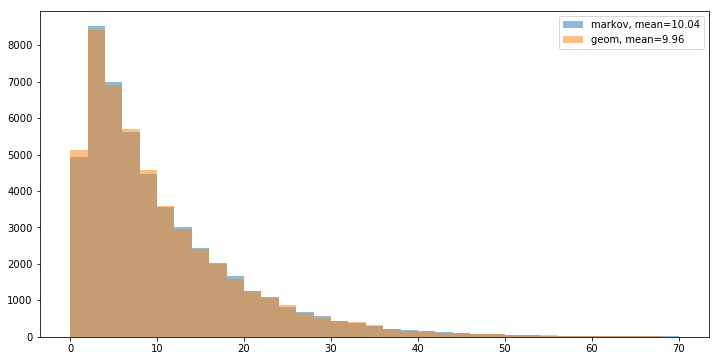

In [179]:
plt.figure(figsize=(12,6))

bins = np.arange(0, 71, 2)
plt.hist(markov, bins=bins, alpha=0.5, label=f'markov, mean={np.mean(markov):.2f}')
plt.hist(geom, bins=bins, alpha=0.5, label=f'geom, mean={np.mean(geom):.2f}')

plt.legend()
plt.show()

In [42]:
import random

class Event:
    def __init__(self, time, priority):
        self.time = time
        self.priority = priority
        self.tiebreak = random.random()
    
    def __lt__(self, other):
        return (
            (self.time, self.priority, self.tiebreak) 
            < (other.time, other.priority, other.tiebreak)
        )

In [43]:
random.seed(1)
n = 20
times = [random.randint(0, 20) for _ in range(n)]
priorities = [random.randint(0, 5) for _ in range(n)]
events = [Event(t, p) for t, p in zip(times, priorities)]

for ev in events:
    print(f't={ev.time:<2}: p={ev.priority}')

print('\nsorted:')
events.sort()
for ev in events:
    print(f't={ev.time:<2}: p={ev.priority}, {ev.tiebreak:.2f}')

t=4 : p=5
t=18: p=1
t=2 : p=4
t=8 : p=0
t=3 : p=2
t=15: p=0
t=14: p=0
t=15: p=0
t=20: p=5
t=12: p=4
t=6 : p=0
t=3 : p=3
t=15: p=5
t=0 : p=1
t=12: p=3
t=13: p=5
t=19: p=0
t=0 : p=4
t=14: p=1
t=8 : p=3

sorted:
t=0 : p=1, 0.30
t=0 : p=4, 0.50
t=2 : p=4, 0.35
t=3 : p=2, 0.76
t=3 : p=3, 0.63
t=4 : p=5, 0.94
t=6 : p=0, 0.10
t=8 : p=0, 0.68
t=8 : p=3, 0.51
t=12: p=3, 0.74
t=12: p=4, 0.92
t=13: p=5, 0.90
t=14: p=0, 0.93
t=14: p=1, 0.97
t=15: p=0, 0.42
t=15: p=0, 0.95
t=15: p=5, 0.72
t=18: p=1, 0.55
t=19: p=0, 0.97
t=20: p=5, 0.92


In [49]:
new_event = Event(time=3, priority=6)
bisect.insort(events, new_event)

In [52]:
for ev in events:
    print(f't={ev.time:<2}: p={ev.priority}, {ev.tiebreak:.2f}')

t=0 : p=4, 0.50
t=2 : p=4, 0.35
t=3 : p=-1, 0.19
t=3 : p=2, 0.76
t=3 : p=3, 0.63
t=3 : p=6, 0.28
t=4 : p=5, 0.94
t=6 : p=0, 0.10
t=8 : p=0, 0.68
t=8 : p=3, 0.51
t=12: p=3, 0.74
t=12: p=4, 0.92
t=13: p=5, 0.90
t=14: p=0, 0.93
t=14: p=1, 0.97
t=15: p=0, 0.42
t=15: p=0, 0.95
t=15: p=5, 0.72
t=18: p=1, 0.55
t=19: p=0, 0.97
t=20: p=5, 0.92


In [51]:
ev = events.pop(0)
print(ev.time, ev.priority, ev.tiebreak)

0 1 0.2963903927869346


In [4]:
from simantha.parallel_test import ParallelMachine

In [5]:
sim = ParallelMachine()

sim.simulate(until=100, verbose=True)

Parts made: 1 at t=6
Parts made: 2 at t=15
Parts made: 3 at t=20
Parts made: 4 at t=27
Parts made: 5 at t=32
Parts made: 6 at t=40
Parts made: 7 at t=48
Parts made: 8 at t=56
Parts made: 9 at t=66
Parts made: 10 at t=74
Parts made: 11 at t=80
Parts made: 12 at t=85
Parts made: 13 at t=93
Parts made: 14 at t=98


In [6]:
random.seed(1)

n = 100000
start = time.time()
result_serial = sim.iterate_simulation(replications=n, until=100)
stop = time.time()
print(f'Finished in {stop-start:.2f}s')

Finished in 3.55s


In [7]:
start = time.time()
result_parallel = sim.iterate_simulation(replications=n, until=100, jobs=10)
stop = time.time()
print(f'Finished in {stop-start:.2f}s')

Finished in 1.13s


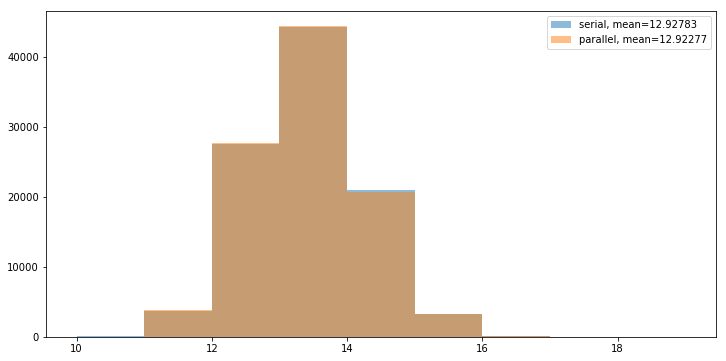

In [13]:
plt.figure(figsize=(12,6))

bins = np.arange(10,20,1)
plt.hist(result_serial, bins=bins, alpha=0.5, label=f'serial, mean={np.mean(result_serial)}')
plt.hist(result_parallel, bins=bins, alpha=0.5, label=f'parallel, mean={np.mean(result_parallel)}')

#plt.title(f'Average production: {np.mean(result_parallel)} units')
plt.legend()

plt.show()

In [9]:
result = sim.iterate_simulation(replications=10000, until=100, jobs=8)

In [2]:
def print_trace():
    trace = pd.DataFrame(pd.read_pickle('environment_trace.pkl'))[['time', 'location', 'action', 'source', 'status', 'priority']]
    return trace

In [3]:
# single machine
source = Source()
M1 = Machine(name='M1', cycle_time=1)
B1 = Buffer('B1', capacity=3)
M2 = Machine(name='M2', cycle_time=1)
sink = Sink()

objects = [source, M1, B1, M2, sink]

source.define_routing(downstream=[M1])
M1.define_routing(upstream=[source], downstream=[B1])
B1.define_routing(upstream=[M1], downstream=[M2])
M2.define_routing(upstream=[B1], downstream=[sink])
sink.define_routing(upstream=[M1])

system = System(objects=objects)

system.simulate(simulation_time=100, trace=True)

Simulation finished in 0.01s
Parts produced: 99


In [6]:
print_trace().to_csv('C:/Users/Michael/Downloads/trace.csv')

In [4]:
%tb

SystemExit: 

In [8]:
B1.reserved_content

1

In [17]:
# single machine
source = Source()
M1 = Machine(name='M1', cycle_time=1, planned_failure=(1, 10))
B1 = Buffer('B1', capacity=1)
M2 = Machine(name='M2', cycle_time=1, planned_failure=(11, 10))
sink = Sink()

objects = [source, M1, B1, M2, sink]

source.define_routing(downstream=[M1])
M1.define_routing(upstream=[source], downstream=[B1])
B1.define_routing(upstream=[M1], downstream=[M2])
M2.define_routing(upstream=[B1], downstream=[sink])
sink.define_routing(upstream=[M1])

system = System(objects=objects)

system.simulate(simulation_time=100, trace=True)

Simulation finished in 0.01s
Parts produced: 80


In [15]:
pd.DataFrame(M2.maintenance_data)[['time', 'event']]

,time,event
0,11,planned failure
1,21,repaired


In [18]:
pd.DataFrame(M1.production_data)[['time', 'production']]

,time,production
0,0,0
1,1,1
2,12,2
3,21,3
4,22,4
5,23,5
6,24,6
7,25,7
8,26,8
9,27,9


In [8]:
# 2m1b
source = Source()
M1 = Machine(name='M1', cycle_time=1)
B1 = Buffer('B1', capacity=10)
M2 = Machine(name='M2', cycle_time=4)
sink = Sink()

objects = [source, M1, B1, M2, sink]

source.define_routing(downstream=[M1])
M1.define_routing(upstream=[source], downstream=[B1])
B1.define_routing(upstream=[M1], downstream=[M2])
M2.define_routing(upstream=[B1], downstream=[sink])
sink.define_routing(upstream=[M2])

system = System(objects=objects)

random.seed(1)
system.simulate(simulation_time=100, trace=True)

Simulation finished in 0.01s
Parts produced: 24


In [4]:
trace = pd.DataFrame(pd.read_pickle('trace.pkl'))[['time', 'location', 'action', 'group', 'order', 'priority']]
trace

,time,location,action,group,order,priority
0,0,M1,get_part,1,1,0
1,1,M1,request_space,2,2,0
2,1,M1,put_part,2,3,0
3,1,M2,request_part,3,4,0
4,1,M2,get_part,3,5,0
5,1,M1,request_part,3,6,0
6,1,M1,get_part,3,7,0
7,2,M1,request_space,4,8,0
8,2,M1,put_part,4,9,0
9,2,M1,request_part,5,10,0


In [16]:
# three machine parallel station
# 2m1b
source = Source()
M1 = Machine(name='M1', cycle_time=1)
B1 = Buffer('B1', capacity=10)
M2 = Machine(name='M2', cycle_time=3)
M3 = Machine(name='M3', cycle_time=3)
M4 = Machine(name='M4', cycle_time=3)
sink = Sink()

objects = [source, M1, B1, M2, M3, M4, sink]

source.define_routing(downstream=[M1])

M1.define_routing(upstream=[source], downstream=[B1])

B1.define_routing(upstream=[M1], downstream=[M2, M3, M4])

M2.define_routing(upstream=[B1], downstream=[sink])
M3.define_routing(upstream=[B1], downstream=[sink])
M4.define_routing(upstream=[B1], downstream=[sink])

sink.define_routing(upstream=[M2, M3, M4])

system = System(objects=objects)

random.seed(1)
system.simulate(simulation_time=10000, trace=True)

Simulation finished in 0.78s
Parts produced: 9997


In [6]:
trace = pd.DataFrame(pd.read_pickle('trace.pkl'))[['time', 'location', 'action', 'group', 'order', 'priority']]
trace

,time,location,action,group,order,priority
0,0,M1,get_part,1,1,0
1,1,M1,request_space,2,2,0
2,1,M1,put_part,2,3,0
3,1,M4,request_part,3,4,0
4,1,M4,get_part,3,5,0
5,1,M3,request_part,3,6,0
6,1,M2,request_part,3,7,0
7,1,M1,request_part,3,8,0
8,1,M1,get_part,3,9,0
9,2,M1,request_space,4,10,0


In [8]:
# 2m1b with degradation
Q = generate_degradation_matrix(h_max=10, p=0.)
cm = {'uniform': [20, 30]}

source = Source()
M1 = Machine(
    name='M1', 
    cycle_time=1,
    degradation_matrix=Q,
    cm_distribution=cm
)
B1 = Buffer('B1', capacity=10)
M2 = Machine(
    name='M2', 
    cycle_time=1,
    degradation_matrix=Q,
    cm_distribution=cm
)
sink = Sink()

objects = [source, M1, B1, M2, sink]

source.define_routing(downstream=[M1])
M1.define_routing(upstream=[source], downstream=[B1])
B1.define_routing(upstream=[M1], downstream=[M2])
M2.define_routing(upstream=[B1], downstream=[sink])
sink.define_routing(upstream=[M2])

repairman = Repairman(capacity=2)
system = System(objects=objects, repairman=repairman)

random.seed(1)
system.simulate(simulation_time=1000, trace=True)

Simulation finished in 0.12s
Parts produced: 999


In [6]:
print_trace().to_csv('C:/Users/Michael/Downloads/trace.csv')

In [7]:
pd.DataFrame(M1.maintenance_data)[['time', 'event']]

,time,event
0,76,enter queue
1,76,failure
2,76,begin maintenance
3,102,repaired
4,259,enter queue
5,259,failure
6,259,begin maintenance
7,288,repaired
8,472,enter queue
9,472,failure


In [5]:
%tb

SystemExit: 

In [11]:
print_trace()#.to_csv('C:/Users/Michael/Downloads/trace.csv')

,time,location,action,status,group,order,priority
0,0,M1,get_part,succeeded,1,1,0
1,1,M1,put_part,succeeded,2,2,0
2,1,M1,request_space,succeeded,2,3,0
3,1,M2,degrade,succeeded,2,4,0
4,1,M2,get_part,succeeded,3,5,0
5,1,M2,request_part,succeeded,3,6,0
6,1,M1,get_part,succeeded,3,7,0
7,1,M1,request_part,succeeded,3,8,0
8,2,M1,put_part,succeeded,4,9,0
9,2,M1,request_space,succeeded,4,10,0


In [3]:
# 2m1b with degradation
Q = utils.generate_degradation_matrix(h_max=10, p=0.1)
cm = {'uniform': [20, 30]}

source = Source()
M1 = Machine(
    name='M1', 
    cycle_time=1,
    degradation_matrix=Q,
    cm_distribution=cm
)
B1 = Buffer('B1', capacity=10)
M2 = Machine(
    name='M2', 
    cycle_time=3,
    degradation_matrix=Q,
    cm_distribution=cm
)
sink = Sink()

objects = [source, M1, B1, M2, sink]

source.define_routing(downstream=[M1])
M1.define_routing(upstream=[source], downstream=[B1])
B1.define_routing(upstream=[M1], downstream=[M2])
M2.define_routing(upstream=[B1], downstream=[sink])
sink.define_routing(upstream=[M2])

repairman = Repairman(capacity=2)
system = System(objects=objects, repairman=repairman)

random.seed(1)
system.simulate(simulation_time=100000, trace=True, debug=0)

NameError: name 'utils' is not defined

In [60]:
# complex line
p = 0.1
h_max = 10
buffer_capacity = 10

Q = generate_degradation_matrix(p=p, h_max=h_max)
pm = {'uniform': [5, 15]}
cm = {'uniform': [20, 40]}

cycle_times = [1, 1, 3, 3, 3, 2, 2, 1, 1]

source = Source()
machines = [0] + [
    Machine(
        name=f'M{i}',
        cycle_time=ct,
        degradation_matrix=Q,
        pm_distribution=pm,
        cm_distribution=cm
    ) for i, ct in zip(range(1, 10), cycle_times)
]
buffers = [0] + [Buffer('B{i}', capacity=buffer_capacity) for i in range(4)]
sink = Sink()

In [7]:
s = [[0, 1], [2, 3], [3, 4], [5], [6]]

In [8]:
[item for sublist in s for item in sublist]

[0, 1, 2, 3, 3, 4, 5, 6]

In [3]:
flat_list = [item for sublist in l for item in sublist]

NameError: name 'l' is not defined

In [61]:
source.define_routing(downstream=[machines[1]])
machines[1].define_routing(upstream=[source], downstream=[buffers[1]])
buffers[1].define_routing(upstream=[machines[1]], downstream=[machines[2]] + machines[6:8])
machines[2].define_routing(upstream=[buffers[1]], downstream=[buffers[2]])
buffers[2].define_routing(upstream=[machines[2]], downstream=machines[3:6])
for machine in machines[3:6]:
    machine.define_routing(upstream=[buffers[2]], downstream=[buffers[4]])
for machine in machines[6:8]:
    machine.define_routing(upstream=[buffers[1]], downstream=[buffers[3]])
buffers[3].define_routing(upstream=machines[6:8], downstream=[machines[8]])
machines[8].define_routing(upstream=[buffers[3]], downstream=[buffers[4]])
buffers[4].define_routing(upstream=machines[3:6]+[machines[8]], downstream=[machines[9]])
machines[9].define_routing(upstream=[buffers[4]], downstream=[sink])
sink.define_routing(upstream=[machines[9]])

In [62]:
system = System(objects=[source] + machines[1:]+buffers[1:] + [sink])

In [63]:
system.simulate(simulation_time=100000, debug=False, trace=True)

Simulation finished in 21.71s
Parts produced: 90864


In [64]:
len(print_trace())#.to_csv('C:/Users/Michael/Downloads/trace2.csv')

1810586

In [ ]:
def plot_production(machine):
    plt.plot(machine.production_data['production'], label=machine.name)

In [66]:
help(Machine)

Help on class Machine in module simantha.Machine:

class Machine(simantha.Asset.Asset)
 |  Parent class for assets in the system. All objects should extend this class, and
 |  there should be no instances.
 |  
 |  Method resolution order:
 |      Machine
 |      simantha.Asset.Asset
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, name=None, cycle_time=1, selection_priority=1, degradation_matrix=[[1, 0], [0, 1]], cbm_threshold=None, pm_distribution=5, cm_distribution=10, initial_health=0, initial_remaining_process=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  can_give(self)
 |  
 |  can_receive(self)
 |  
 |  cancel_all_events(self)
 |  
 |  define_routing(self, upstream=[], downstream=[])
 |  
 |  degrade(self)
 |  
 |  enter_queue(self)
 |  
 |  fail(self)
 |  
 |  get_candidate_givers(self, only_free=False, blocked=False)
 |      Returns a list of assets that can give a part to this asset from among the
 |      u

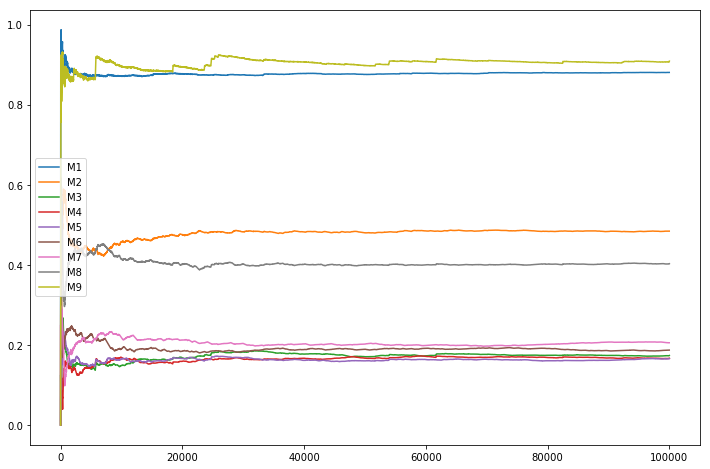

In [65]:
plt.figure(figsize=(12,8))

for machine in machines[1:]:
    th = [volume / (t+1) for volume, t in zip(machine.production_data['production'], machine.production_data['time'])]
    plt.plot(machine.production_data['time'], th, label=machine.name)
    
plt.legend()

plt.show()

In [54]:
i = 6
machines[i].production_data['production'][-1] / machines[i].production_data['time'][-1] + machines[7].production_data['production'][-1] / machines[7].production_data['time'][-1]

0.5753128679286793

In [48]:
(1/3)*0.25 + (0.5)*(0.25) + (0.5)*(0.25) + (0.25)

0.5833333333333333

In [55]:
for machine in machines[1:]:
    print(f'{machine.name}: {machine.parts_made}')

M1: 100000
M2: 42467
M3: 14188
M4: 14270
M5: 14009
M6: 28679
M7: 28852
M8: 57530
M9: 99995
